In [1]:
# import
from shapely.ops import cascaded_union  # , unary_union
import matplotlib.pyplot as plt
import tempfile
import urllib
import base64
import h3
from shapely.geometry import mapping
from geopandas import GeoDataFrame
import xarray as xr
import geopandas
import rtree
import shapely
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# import matplotlib
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

#Functions


def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16, 12), colormap='viridis'):
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col, edgecolors='none',
                    colormap=colormap, marker=marker, alpha=alpha, figsize=figsize)
    plt.xticks([], [])
    plt.yticks([], [])


def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(
        lambda x: h3.h3_to_parent(x, coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[
        [metric_col, ]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfc


def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]]
    dfk.index = dfk[hex_col]
    dfs = (dfk[hex_col]
           .apply(lambda x: pd.Series(list(h3.k_ring(x, k)))).stack()
           .to_frame('hexk').reset_index(1, drop=True).reset_index()
           .merge(df[[hex_col, metric_col]]).fillna(0)
           .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
           .reset_index()
           .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs


def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]

    # weighted smoothing
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col, inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K = len(coef)-1
    for k in range(1, K+1):
        temp2.append((df_agg['hexk']
                      .apply(lambda x: pd.Series(list(h3.hex_ring(x, k)))).stack()
                      .to_frame('hexk').reset_index(1, drop=True).reset_index()
                      ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x: coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(
        index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs


In [37]:
# Translate tif to XYZ dataframe
temp_data = xr.open_rasterio(
    r"./福建省GDP/gdp1.tif")
temp_data.attrs['crs'] = 'EPSG:4326'

df = (temp_data
      .sel(band=1)
      .to_pandas()
      .stack()
      .reset_index()
      .rename(columns={'x': 'lng', 'y': 'lat', 0: 'gdp'}))


In [38]:
df

,lat,lng,gdp
0,29.187452,114.666167,-3.402823e+38
1,29.187452,114.677331,-3.402823e+38
2,29.187452,114.688496,-3.402823e+38
3,29.187452,114.699661,-3.402823e+38
4,29.187452,114.710825,-3.402823e+38
...,...,...,...
402555,22.589130,122.202321,-3.402823e+38
402556,22.589130,122.213485,-3.402823e+38
402557,22.589130,122.224650,-3.402823e+38
402558,22.589130,122.235815,-3.402823e+38


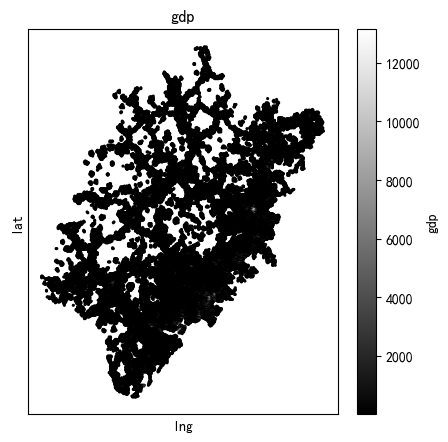

In [39]:
# ignore the missing values
df = df[df.gdp > 0]

# Visualize the elevation
plot_scatter(df, metric_col='gdp', marker='.',
             colormap='gray', figsize=(5, 5))


In [40]:
APERTURE_SIZE = 7
hex_col = 'hex'+str(APERTURE_SIZE)


# find hexs containing the points
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

# calculate elevation average per hex
df_dem = df.groupby(hex_col)['gdp'].sum().to_frame('gdp').reset_index()
 
#find center of hex for visualization
df_dem['lat'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_dem['lng'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])


In [41]:
df_dem

,hex7,gdp,lat,lng
0,8741120b6ffffff,0.393263,24.125140,116.925261
1,874112114ffffff,0.309864,23.901241,116.948169
2,874112116ffffff,0.759317,23.920900,116.955474
3,874112186ffffff,0.330861,24.016765,116.969893
4,874112190ffffff,0.315271,24.056022,116.984507
...,...,...,...,...
17134,8741b5bb0ffffff,33.255585,25.797222,119.605324
17135,8741b5bb1ffffff,82.426765,25.795573,119.583799
17136,8741b5bb3ffffff,44.905384,25.814361,119.591089
17137,8741b5bb4ffffff,13.174986,25.780082,119.619554


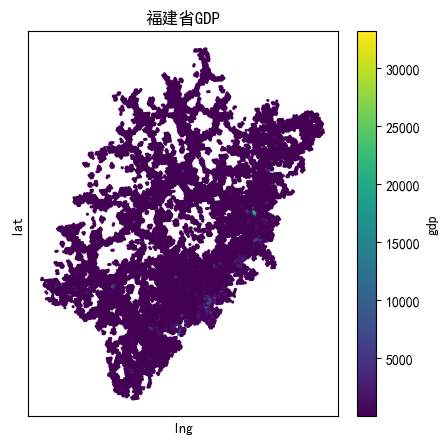

In [42]:
# plot the hexes
plot_scatter(df_dem, metric_col='gdp', figsize=(5, 5))
plt.title('福建省GDP');

Text(0.5, 1.0, 'hex-grid: elevation')

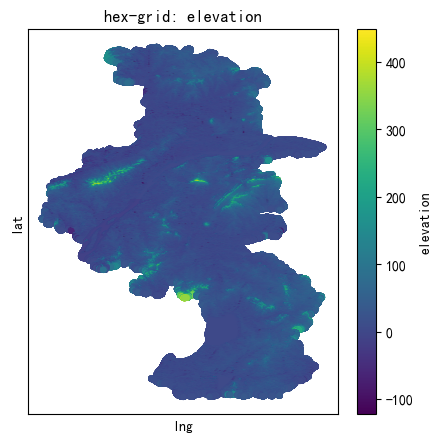

In [8]:
plot_scatter(df, metric_col='elevation', marker='o', figsize=(5, 5))
plt.title('hex-grid: elevation')
